# <center> Projet Machine Learning / Image  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

from keras.models import load_model
from tensorflow.keras.optimizers import Adam 

### Exploration des données

In [2]:
lead_order = ["DI", "DII", "DIII", "AVL", "AVF", "AVR", "V1", "V2", "V3", "V4", "V5", "V6"]
df_Cardiologist2 = pd.read_csv('automatic-ecg-diagnosis-master/data/annotations/cardiologist2.csv')
df_Cardiologist2['nb_abnormality'] =  df_Cardiologist2.sum(axis=1)
print(df_Cardiologist2.T)

                0    1    2    3    4    5    6    7    8    9    ...  817  \
1dAVb             0    0    0    0    0    0    0    0    0    0  ...    0   
RBBB              0    0    0    0    0    0    0    0    0    0  ...    0   
LBBB              0    1    0    0    0    0    0    0    0    0  ...    0   
SB                0    0    0    0    0    0    0    0    0    0  ...    0   
AF                0    0    0    0    0    0    0    0    0    0  ...    0   
ST                0    0    0    0    0    0    0    0    0    0  ...    0   
nb_abnormality    0    1    0    0    0    0    0    0    0    0  ...    0   

                818  819  820  821  822  823  824  825  826  
1dAVb             0    0    0    0    0    0    0    0    1  
RBBB              0    0    0    0    0    0    0    0    0  
LBBB              0    0    0    0    0    0    0    0    0  
SB                0    0    0    0    0    0    0    0    0  
AF                0    0    0    0    0    0    0    0    0  
ST 

Au premier coup d'oeil les données sont un tableau qui met en relation des patients avec des pathologies cardiaques. Il est composé de 0 et de 1, 0 si le patient n'a pas la pathologie et 1 si il l'a.  
Ce que nous voulons de l'algorithme est qu'il prédisse à partir d'ECG si les patients ont ces anomalies ou non.

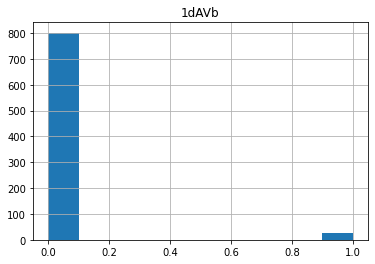

Nombres d'anomalies de type 1dAVb  : 26


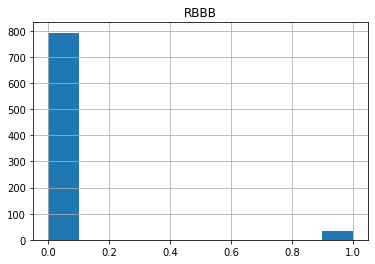

Nombres d'anomalies de type RBBB  : 34


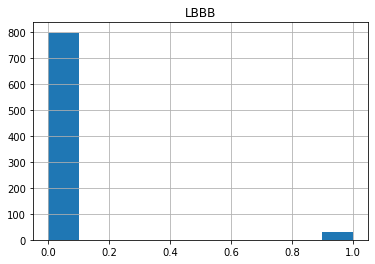

Nombres d'anomalies de type LBBB  : 30


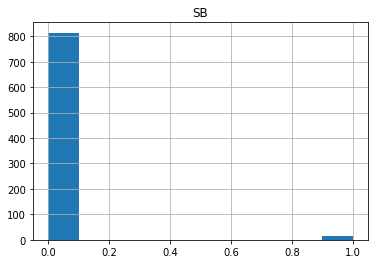

Nombres d'anomalies de type SB  : 13


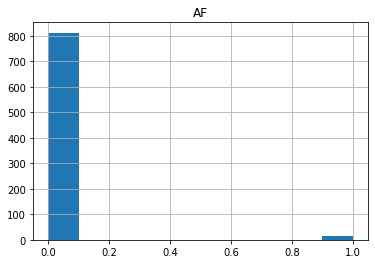

Nombres d'anomalies de type AF  : 14


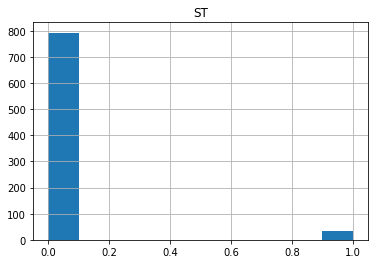

Nombres d'anomalies de type ST  : 34


In [3]:
label = df_Cardiologist2.columns[:-1]
for i in (label):
    df_Cardiologist2[i].hist()
    plt.title(i)
    plt.show()
    print("Nombres d'anomalies de type", i, " :", sum((df_Cardiologist2[i]==1)*1))

Ces histogrammes nous montre le nombre de personnes ayant au moins une pathologie parmis les cinq que nous voulons détecter. Sur ce jeu de donnée nous remarquons que les pathologies sont plutôt bien réparties.
De plus, les pathologies de type "ST" et "RBBB" sont plus courantes suivit de près par "LBBB".  
Il pourrait être intéressant d'étudier la corrélation entre les pathologies, cependant ces données étant trop limitées, il n'est pas possible de trouver des liens. 

In [4]:
mean=[]
variance=[]
for i in label:
    mean.append(np.mean(df_Cardiologist2[i]))
    variance.append(np.var(df_Cardiologist2[i]))

In [5]:
data = pd.DataFrame(index=[label])
data["mean"] = mean
data["variance"] = variance
data

mean  variance
1dAVb  0.031439  0.030451
RBBB   0.041112  0.039422
LBBB   0.036276  0.034960
SB     0.015719  0.015472
AF     0.016929  0.016642
ST     0.041112  0.039422

La moyenne et la variance peuvent aussi nous donner une idée de la répartition des anomalies.

In [6]:
with h5py.File("data/ecg_tracings.hdf5", "r") as f:
    x = np.array(f['tracings'])
print(x.shape)

(827, 4096, 12)


In [7]:
model = load_model("model/model.hdf5", compile=False)
model.compile(loss='binary_crossentropy', optimizer=Adam())

for layer in model.layers:
    print(layer.output_shape)
#print(model.summary())

[(None, 4096, 12)]
(None, 4096, 64)
(None, 4096, 64)
(None, 4096, 64)
(None, 4096, 128)
(None, 4096, 128)
(None, 4096, 128)
(None, 4096, 128)
(None, 1024, 64)
(None, 1024, 128)
(None, 1024, 128)
(None, 1024, 128)
(None, 1024, 128)
(None, 1024, 128)
(None, 1024, 128)
(None, 1024, 196)
(None, 1024, 196)
(None, 1024, 196)
(None, 1024, 196)
(None, 256, 128)
(None, 256, 196)
(None, 256, 196)
(None, 256, 196)
(None, 256, 196)
(None, 256, 196)
(None, 256, 196)
(None, 256, 256)
(None, 256, 256)
(None, 256, 256)
(None, 256, 256)
(None, 64, 196)
(None, 64, 256)
(None, 64, 256)
(None, 64, 256)
(None, 64, 256)
(None, 64, 256)
(None, 64, 256)
(None, 64, 320)
(None, 64, 320)
(None, 64, 320)
(None, 64, 320)
(None, 16, 256)
(None, 16, 320)
(None, 16, 320)
(None, 16, 320)
(None, 16, 320)
(None, 16, 320)
(None, 16, 320)
(None, 5120)
(None, 6)


In [8]:
### gradcam
## grad cam part :

import tensorflow as tf
from keras import backend as k


def find_last_conv(model):
    for layer in reversed(model.layers):
        if len(layer.output_shape) == 3:
            return layer.name


def grad_cam(model, time_serie, class_index, relative=True):
    '''
    version img :
    https://github.com/sicara/tf-explain/blob/master/tf_explain/core/grad_cam.py
    '''
  
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(find_last_conv(model)).output, model.output])
    with tf.GradientTape() as tape:
        inputs = tf.cast([time_serie], tf.float32)
        conv_outputs, predictions = grad_model(inputs)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    A = np.asarray(conv_outputs[0,:,:])
    dy = np.asarray(grads[0,:,:])
    a_k = dy.mean(axis=0)
    heat_map = np.sum(a_k*A, axis=1)
    heat_map = heat_map * (heat_map>0)
  
    if relative :
        heat_map /= heat_map.max()+1e-6
    return heat_map

In [9]:
from scipy.interpolate import interp1d

def plot_grad_cam_ecg(ts, check_y, selected_leads=True, relatives=True):
    hm = grad_cam(model, ts, check_y, relative=relatives)
    hm_interp = interp1d(np.linspace(0,10.24,16), hm, kind='slinear')
    if selected_leads:
        fig, axs = plt.subplots(1, 3,figsize=(40,5))
        for i,pos in enumerate([1,6,11]):
            ax = axs[i]
            ax.set_title(lead_order[pos],fontsize=10)
            ax.plot(np.linspace(0,10.24,4096),ts[:,pos],'k', linewidth=.5)
            t = ax.scatter(np.linspace(0,10.24,4096),ts[:,pos],linewidths=.1,c=hm_interp(np.linspace(0,10.24,4096)))
        fig.colorbar(t,ax=axs)
        plt.show()
    
    else :
        fig, axs = plt.subplots(4, 3,figsize=(20,16))
        for i in range(12):
            ax = axs[i//3, i%3]
            ax.set_title(lead_order[i],fontsize=10)
            ax.plot(np.linspace(0,10.24,4096),ts[:,pos],'k', linewidth=.5)
            t = ax.scatter(np.linspace(0,10.24,4096),ts[:,pos],linewidths=.1,c=hm_interp(np.linspace(0,10.24,4096)))
        fig.colorbar(t,ax=axs)
        plt.show()

### Etude du modèle

Dans l'étude du modèle, nous essayons de comprendre comment l'algorithme arrive à détecter les anomalies et de quel manière sont transmis les résultats.  
Pour cela nous utilisons la méthode **grad-CAM** qui colorie la zone que l'algorithme utilise pour faire ses prédictions.

patient n° 0


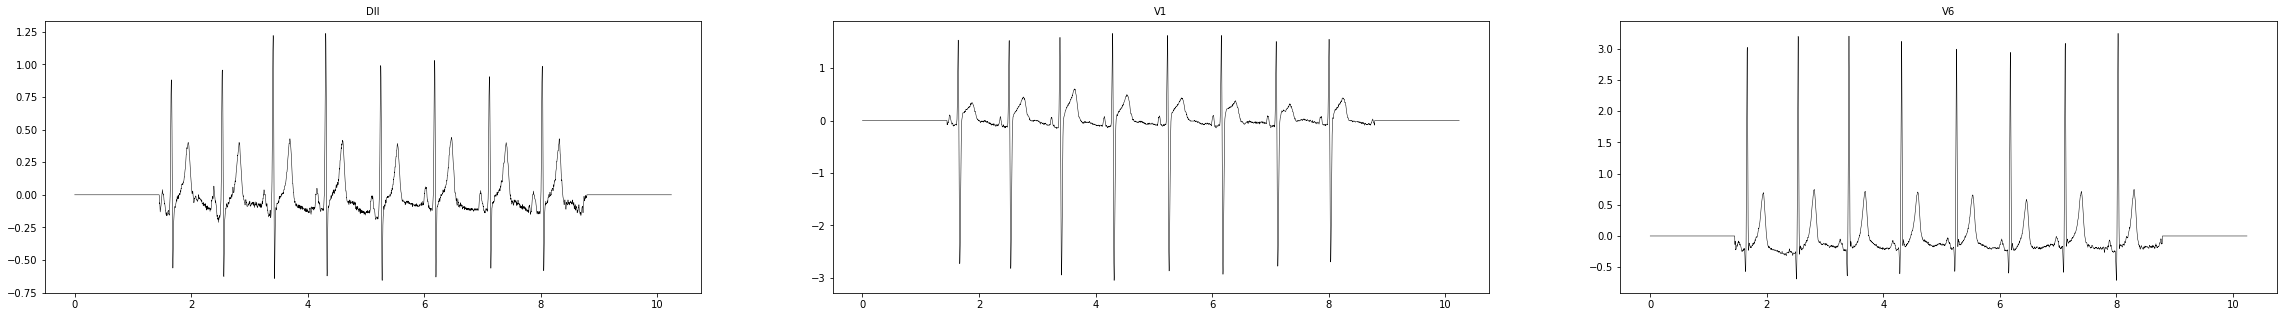

prediction du modèle:  [0. 0. 0. 0. 0. 0.]
patient n° 2


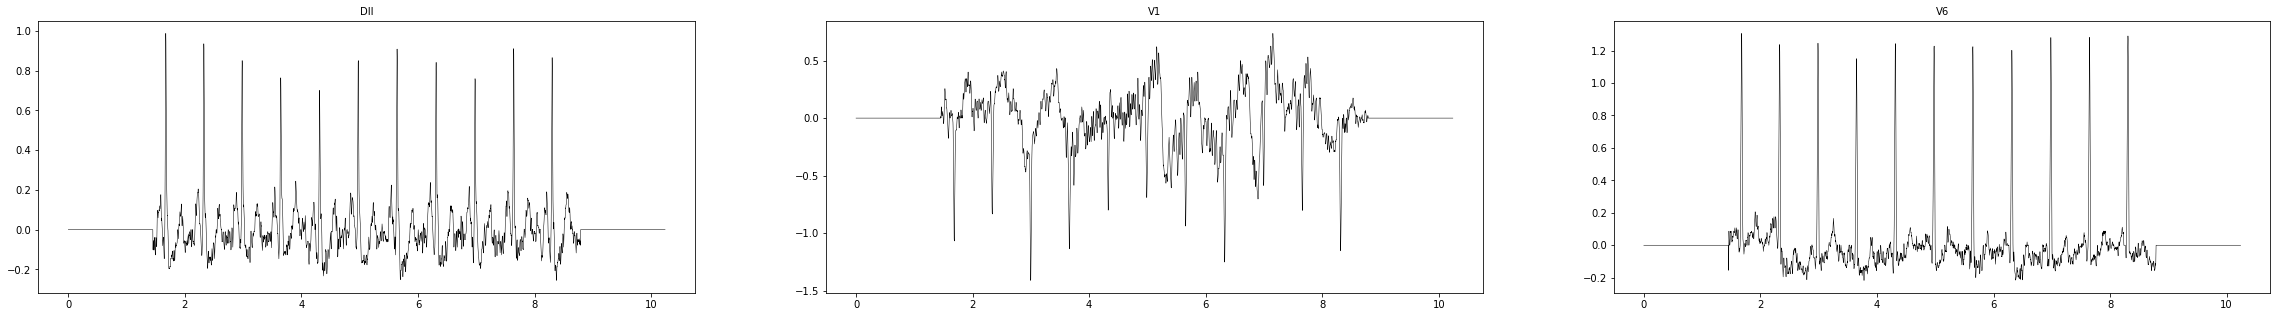

prediction du modèle:  [0. 0. 0. 0. 0. 0.]
patient n° 3


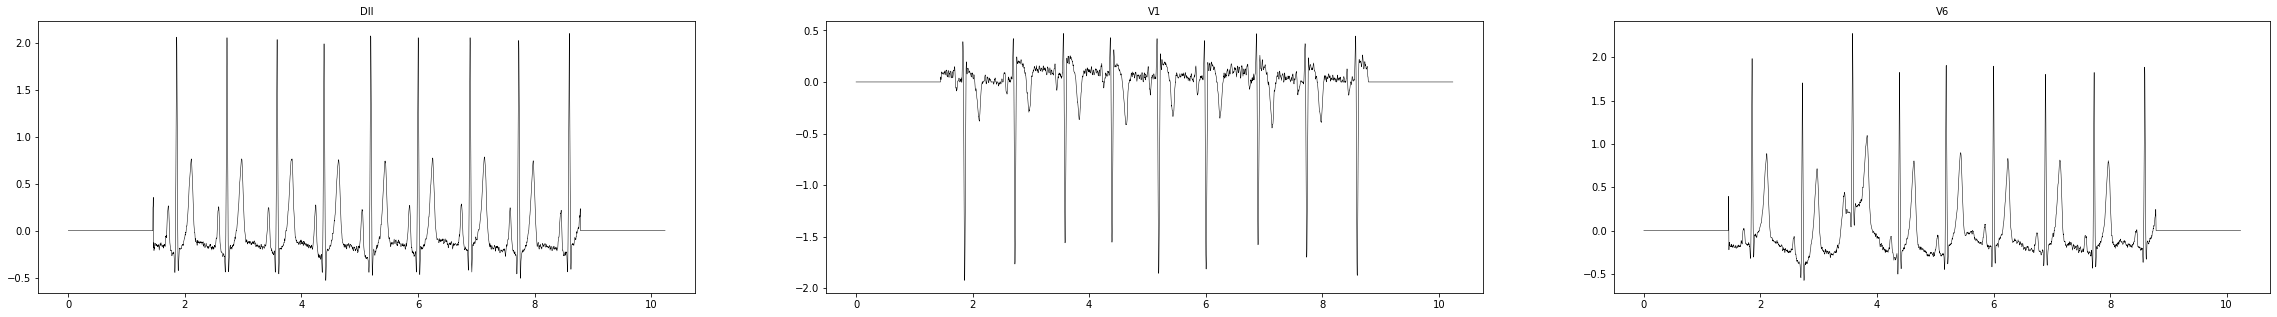

prediction du modèle:  [0. 0. 0. 0. 0. 0.]
patient n° 4


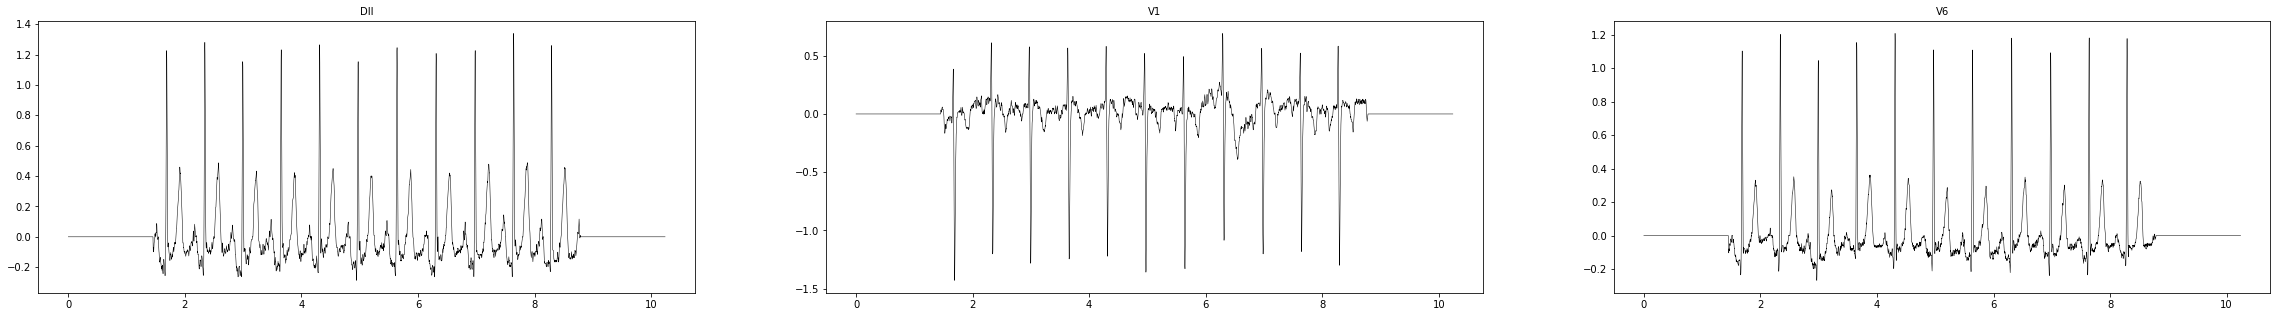

prediction du modèle:  [0. 0. 0. 0. 0. 0.]
patient n° 5


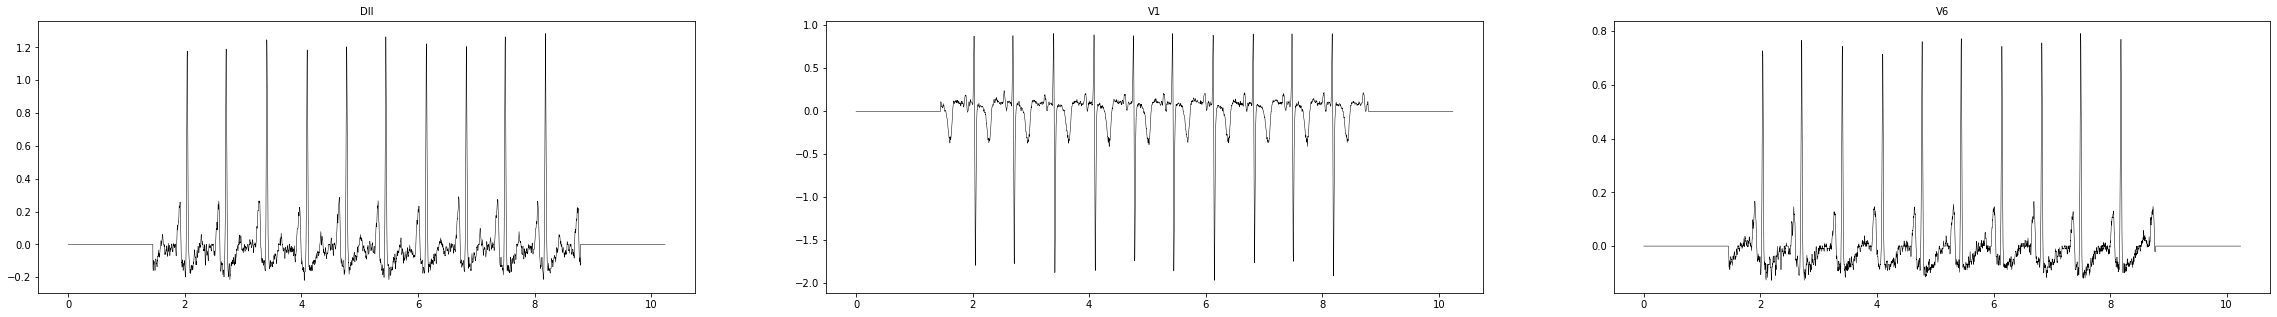

prediction du modèle:  [0. 0. 0. 0. 0. 0.]


In [10]:
preds = model.predict(x[df_Cardiologist2[df_Cardiologist2.nb_abnormality==0].index[:5]])

for i in range (len(preds)):
    preds[i] = np.round(list(preds[i]),4)
for j,idx_safe in enumerate (df_Cardiologist2[df_Cardiologist2.nb_abnormality==0].index[:5]):
    fig, axs = plt.subplots(1, 3,figsize=(40,5))
    for i,pos in enumerate([1,6,11]):
        ax = axs[i]
        ax.set_title(lead_order[pos],fontsize=10)
        ax.plot(np.linspace(0,10.24,4096),x[idx_safe,:,pos],'k', linewidth=.5)
    print("patient n°",idx_safe)
    plt.show()
    print ("prediction du modèle: ",preds[i])

Nous affichons ici les prédictions obtenues pour des patients sains, on voit que pour les patients affichés, le modèle à réussi à prédire que les individus n'avaient aucune anomalie.



###########	 1dAVb	###########

1dAVb             1
RBBB              0
LBBB              0
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 12, dtype: int64
prédiction du modèle:  [0.19 0.   0.   0.   0.   0.  ]


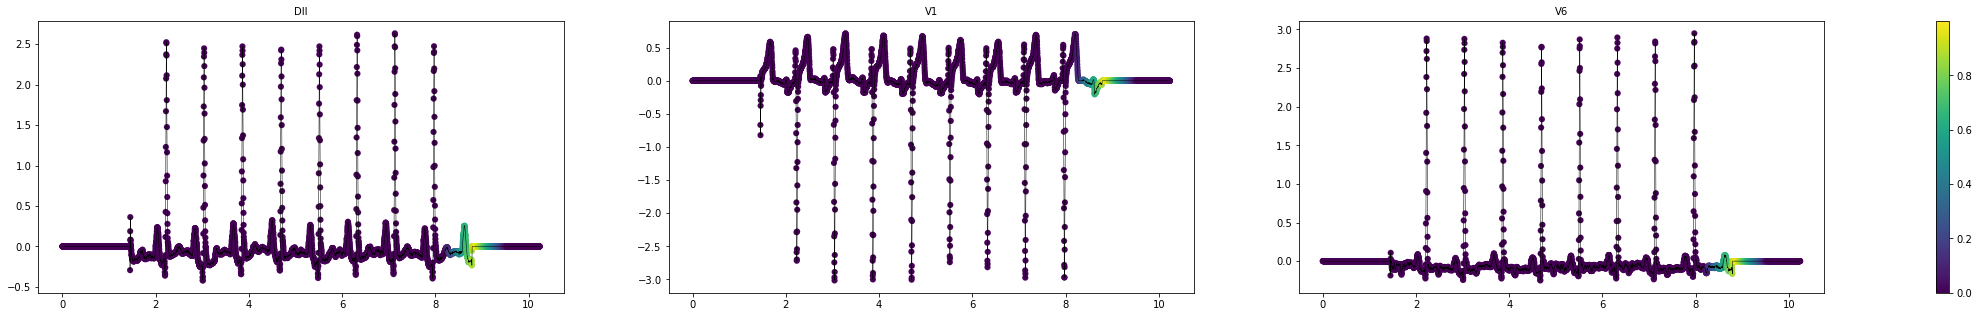

1dAVb             1
RBBB              0
LBBB              0
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 32, dtype: int64
prédiction du modèle:  [0.16 0.   0.   0.   0.06 0.  ]


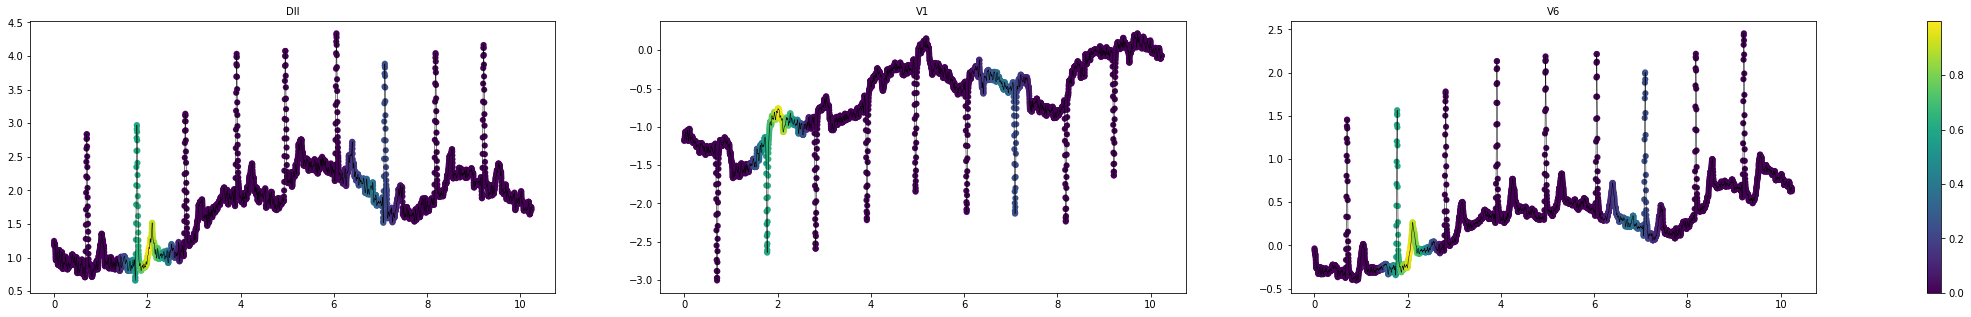

1dAVb             1
RBBB              0
LBBB              0
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 57, dtype: int64
prédiction du modèle:  [0.06 0.   0.   0.   0.   0.  ]


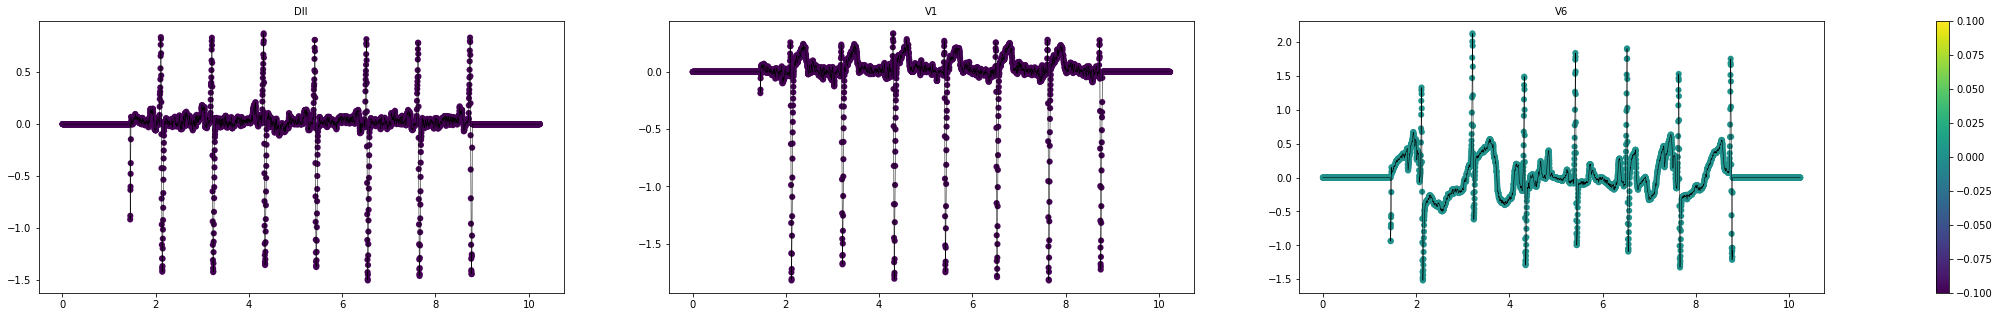



###########	 RBBB	###########

1dAVb             0
RBBB              1
LBBB              0
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 106, dtype: int64
prédiction du modèle:  [0.   0.79 0.   0.   0.   0.  ]


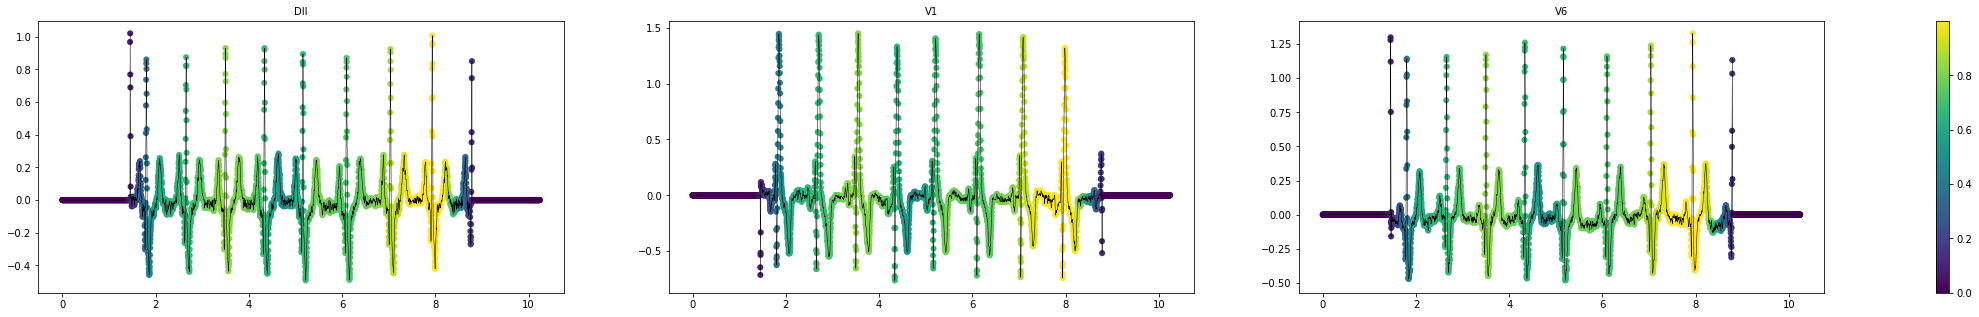

1dAVb             0
RBBB              1
LBBB              0
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 241, dtype: int64
prédiction du modèle:  [0.   0.43 0.   0.   0.   0.  ]


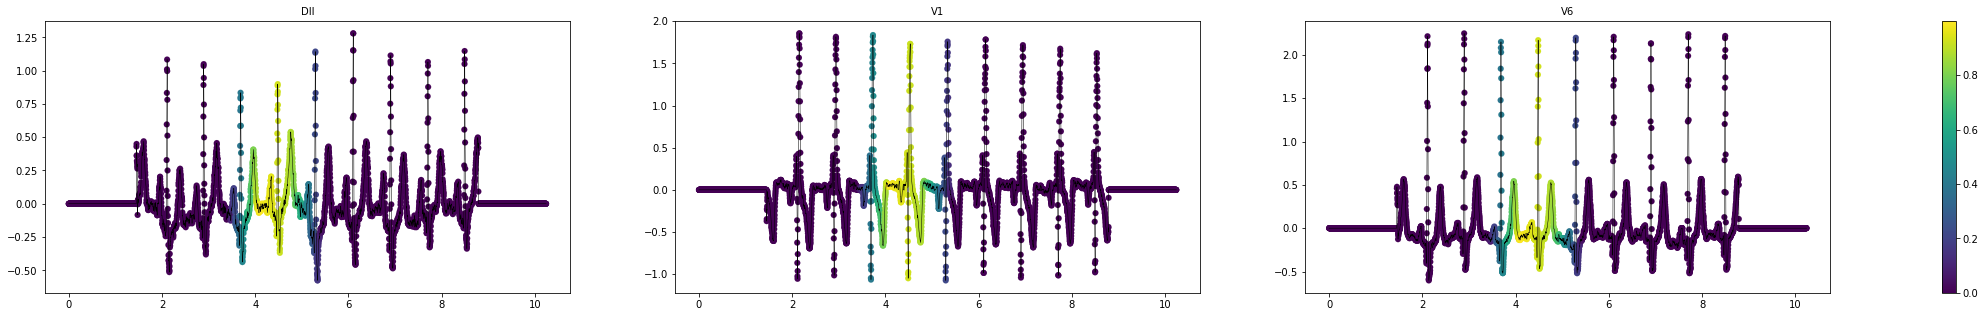

1dAVb             0
RBBB              1
LBBB              0
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 255, dtype: int64
prédiction du modèle:  [0.02 0.74 0.   0.   0.   0.  ]


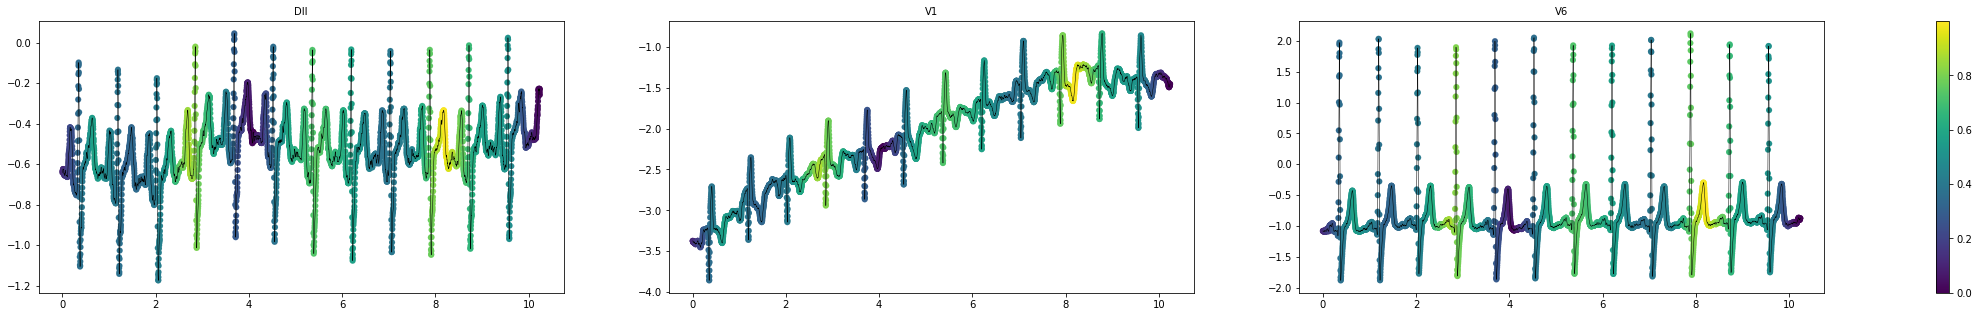



###########	 LBBB	###########

1dAVb             0
RBBB              0
LBBB              1
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 1, dtype: int64
prédiction du modèle:  [0.03 0.   0.32 0.   0.05 0.  ]


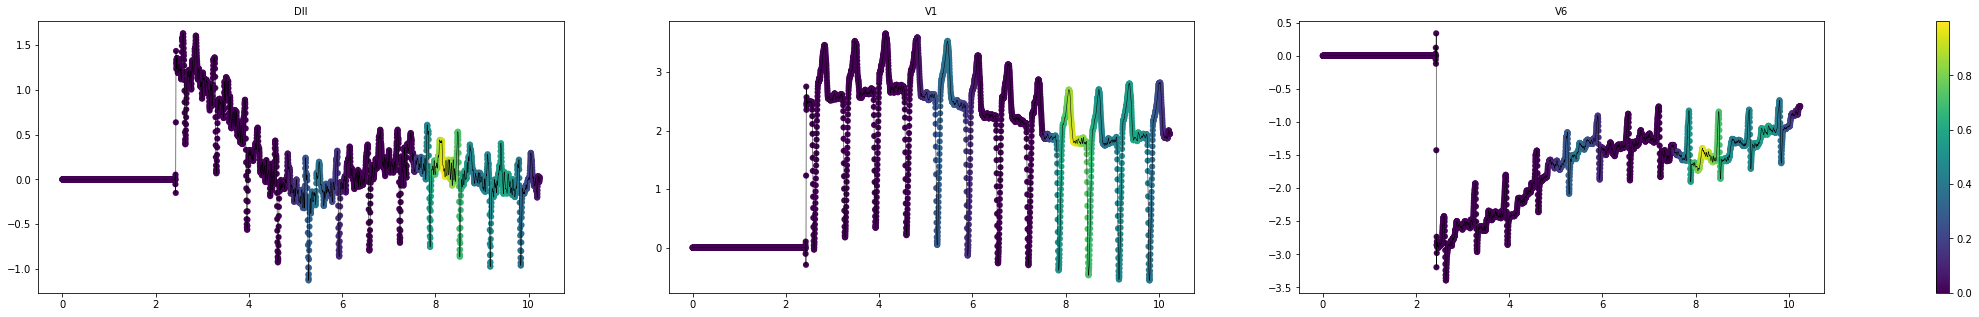

1dAVb             0
RBBB              0
LBBB              1
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 28, dtype: int64
prédiction du modèle:  [0.01 0.   0.84 0.   0.01 0.  ]


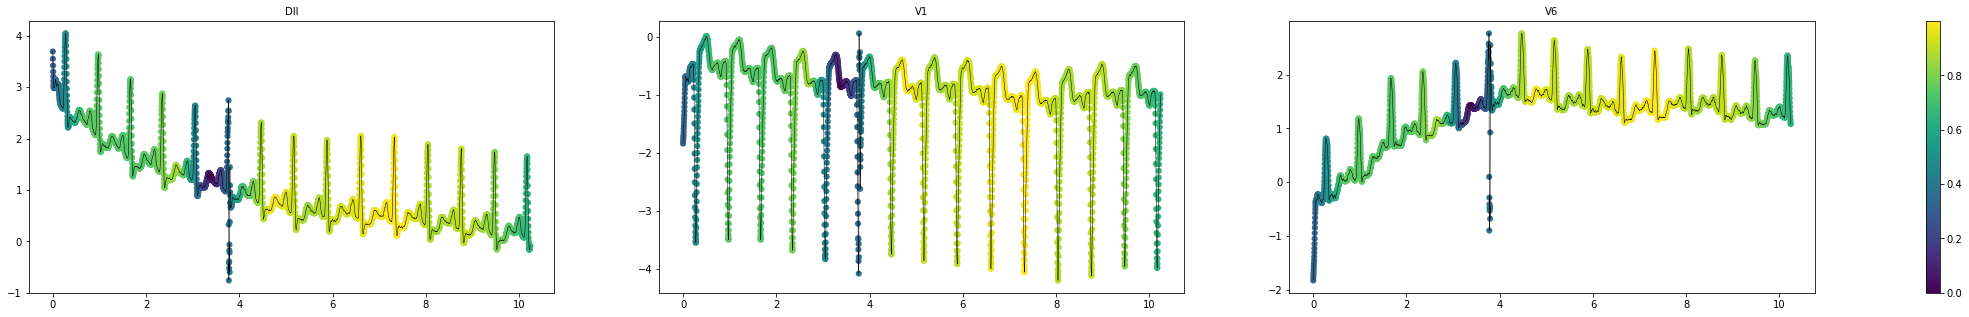

1dAVb             0
RBBB              0
LBBB              1
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 58, dtype: int64
prédiction du modèle:  [0.   0.   0.52 0.   0.   0.  ]


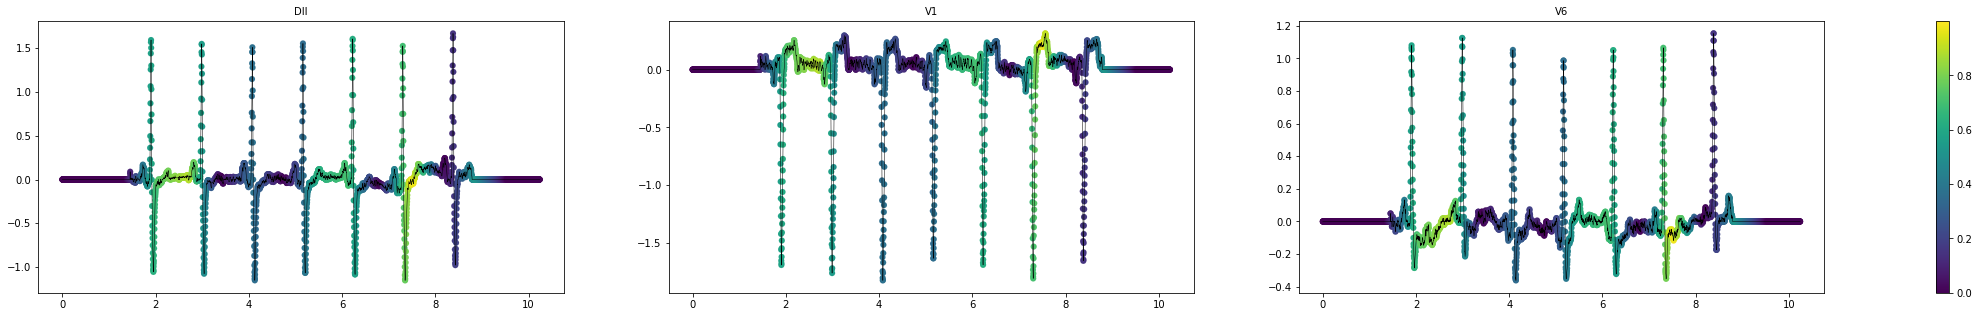



###########	 SB	###########

1dAVb             0
RBBB              0
LBBB              0
SB                1
AF                0
ST                0
nb_abnormality    1
Name: 40, dtype: int64
prédiction du modèle:  [0.   0.   0.   0.61 0.01 0.  ]


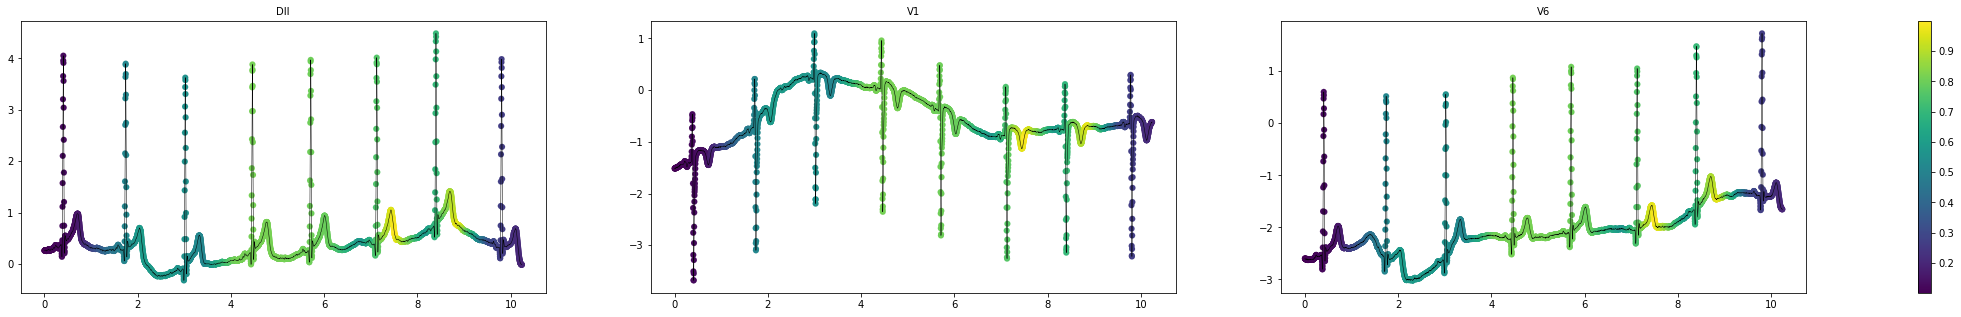

1dAVb             0
RBBB              0
LBBB              0
SB                1
AF                0
ST                0
nb_abnormality    1
Name: 75, dtype: int64
prédiction du modèle:  [0.01 0.01 0.   0.51 0.01 0.  ]


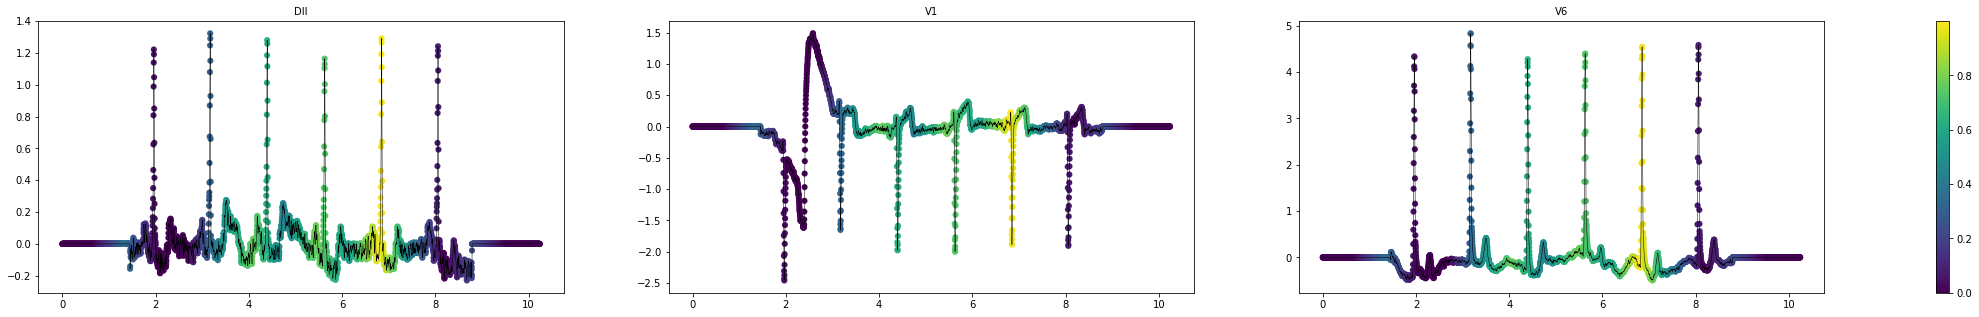

1dAVb             0
RBBB              0
LBBB              0
SB                1
AF                0
ST                0
nb_abnormality    1
Name: 98, dtype: int64
prédiction du modèle:  [0.   0.   0.   0.56 0.   0.  ]


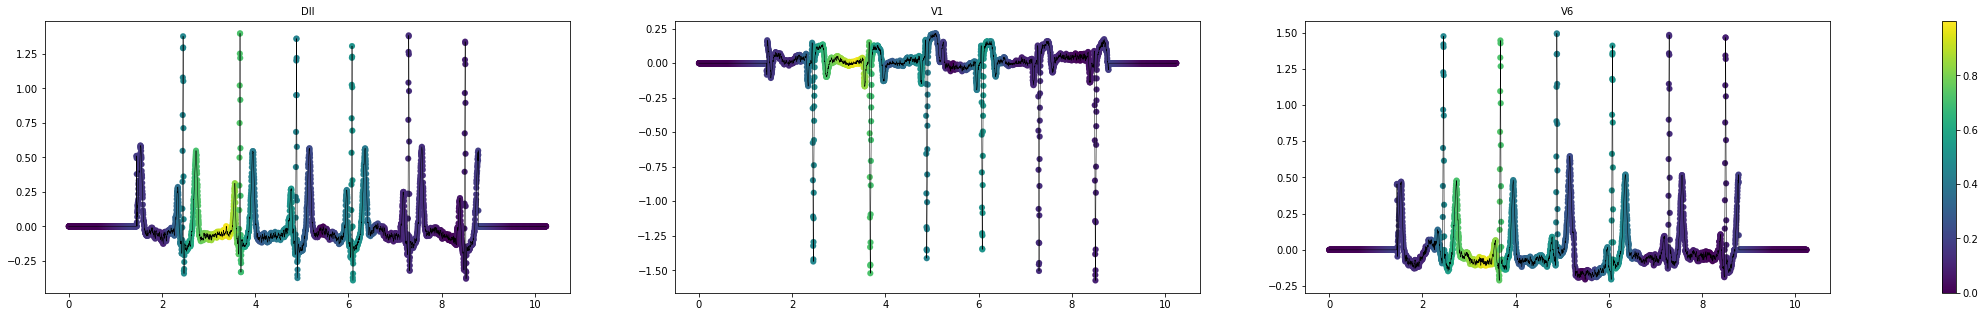



###########	 AF	###########

1dAVb             0
RBBB              0
LBBB              0
SB                0
AF                1
ST                0
nb_abnormality    1
Name: 120, dtype: int64
prédiction du modèle:  [0.   0.   0.   0.   0.94 0.  ]


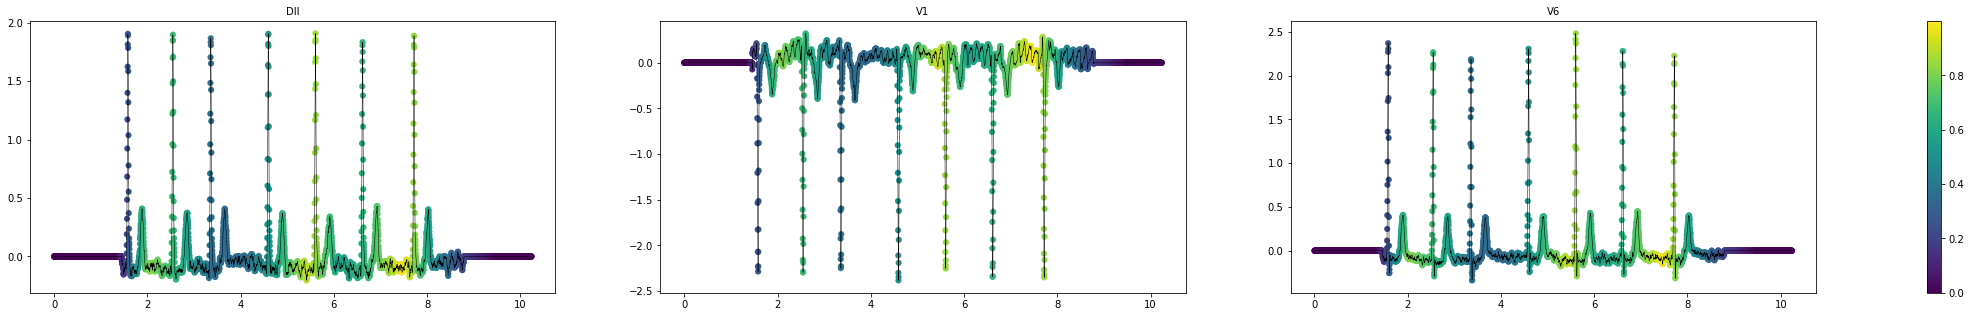

1dAVb             0
RBBB              0
LBBB              0
SB                0
AF                1
ST                0
nb_abnormality    1
Name: 170, dtype: int64
prédiction du modèle:  [0.04 0.   0.   0.   0.21 0.  ]


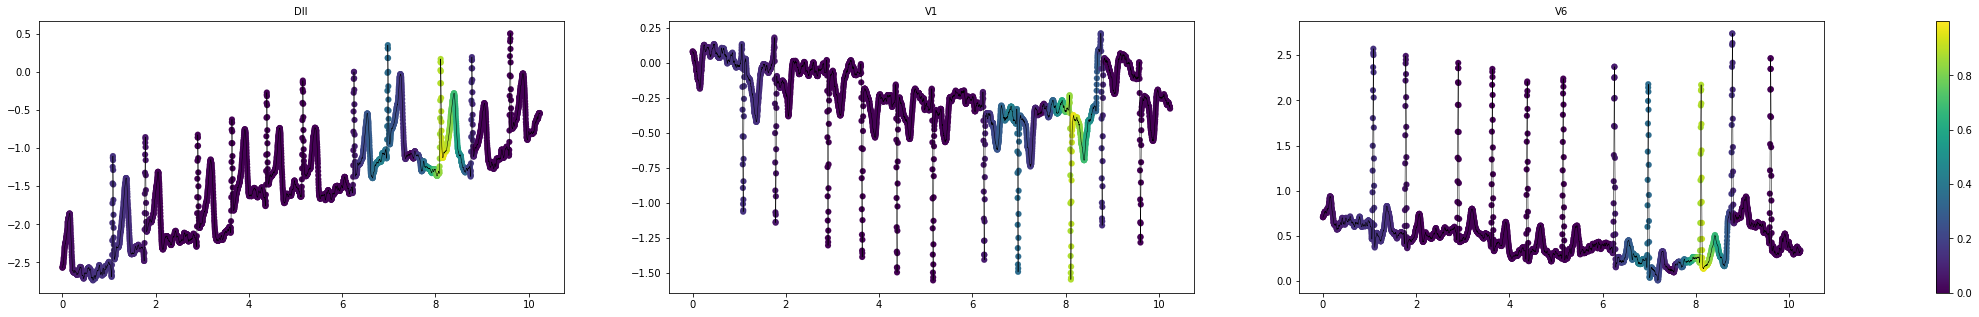

1dAVb             0
RBBB              0
LBBB              0
SB                0
AF                1
ST                0
nb_abnormality    1
Name: 259, dtype: int64
prédiction du modèle:  [0.   0.   0.   0.   0.93 0.  ]


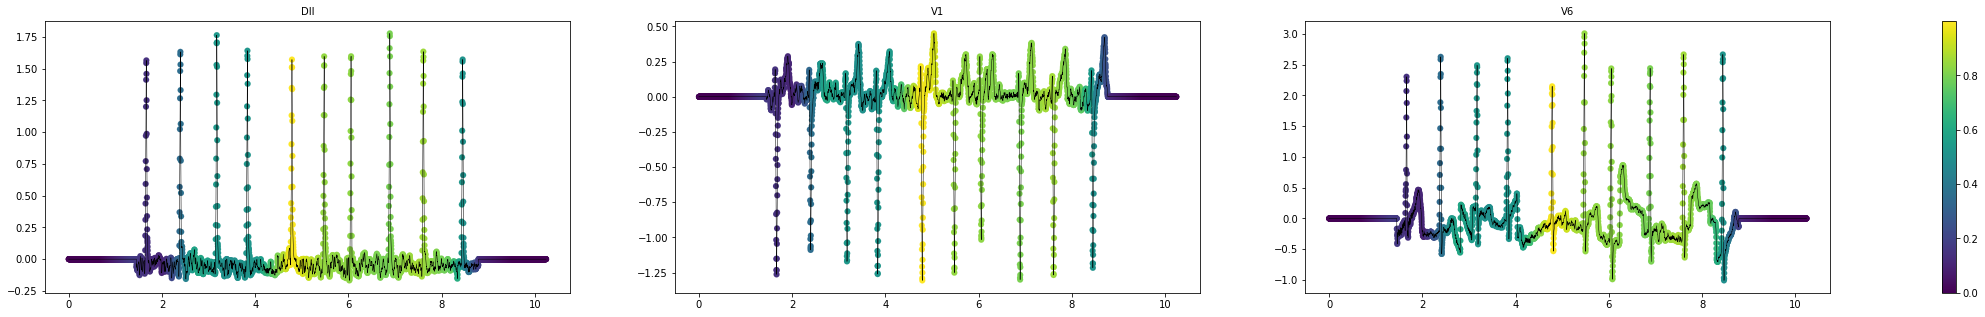



###########	 ST	###########

1dAVb             0
RBBB              0
LBBB              0
SB                0
AF                0
ST                1
nb_abnormality    1
Name: 23, dtype: int64
prédiction du modèle:  [0.   0.   0.   0.   0.05 0.38]


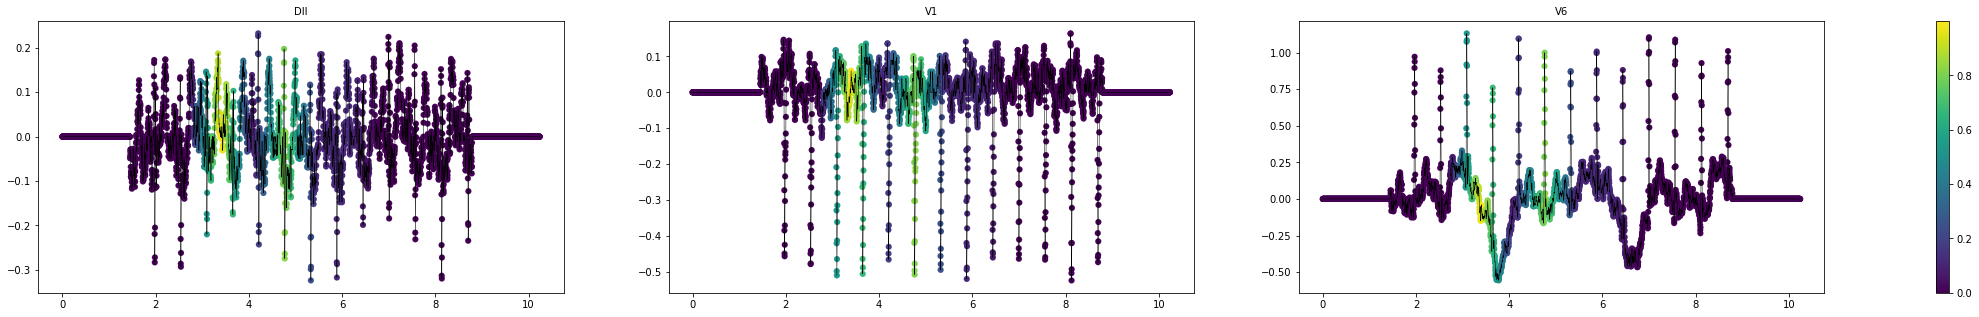

1dAVb             0
RBBB              0
LBBB              0
SB                0
AF                0
ST                1
nb_abnormality    1
Name: 93, dtype: int64
prédiction du modèle:  [0. 0. 0. 0. 0. 0.]


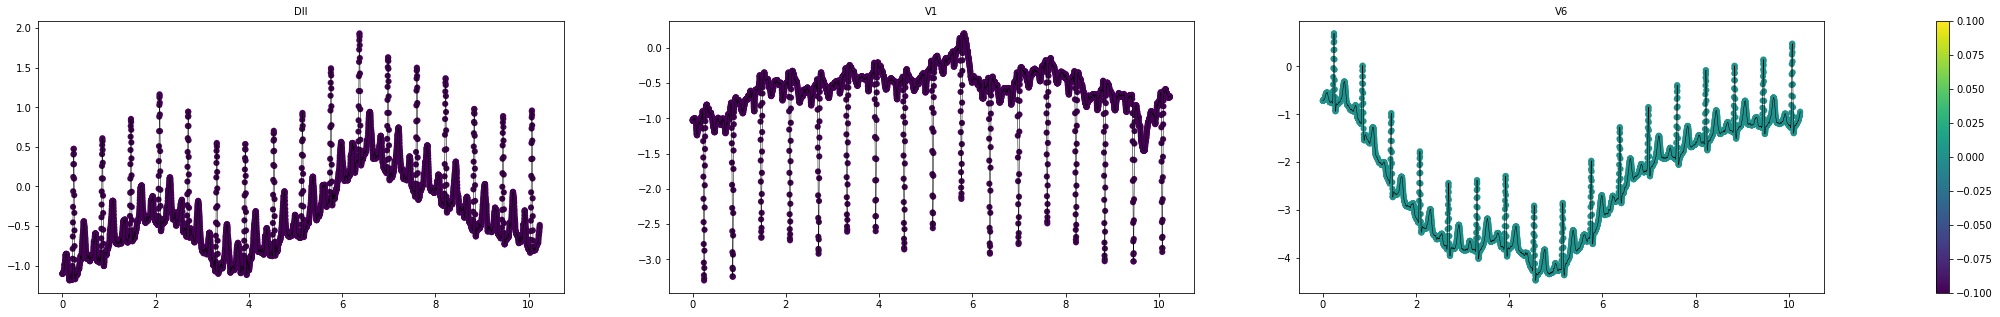

1dAVb             0
RBBB              0
LBBB              0
SB                0
AF                0
ST                1
nb_abnormality    1
Name: 108, dtype: int64
prédiction du modèle:  [0.   0.   0.   0.   0.   0.78]


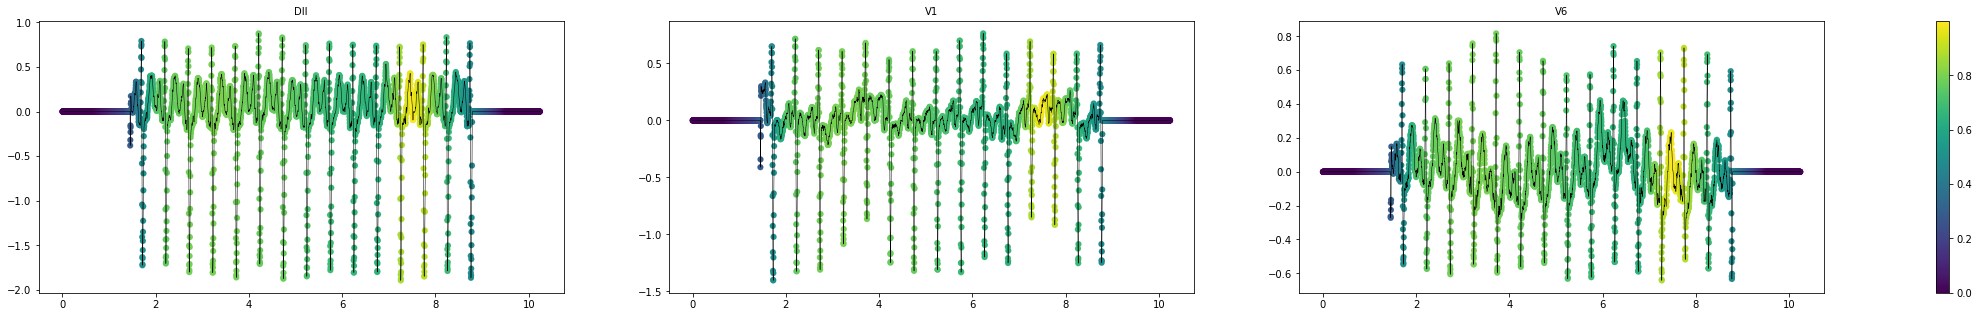

In [11]:
for idx_abn, abnormality in enumerate(df_Cardiologist2.columns[:-1]):
    index_abnormality = df_Cardiologist2[(df_Cardiologist2[abnormality]==1)&(df_Cardiologist2.nb_abnormality==1)].index
    print(f'\n\n###########\t {abnormality}\t###########\n')
    preds = model.predict(x[index_abnormality])
    for i, pos in enumerate(index_abnormality[:3]):
        np.set_printoptions(precision=2,suppress=True)
        print(df_Cardiologist2.iloc[pos])
        print("prédiction du modèle: ",preds[i])
        plot_grad_cam_ecg(x[pos],check_y=idx_abn)

Ici nous affichons les prédictions du modèle sur des sujets malades. Nous affichons la détection des anomalies indépendamment les unes des autres. L'algorithme attribu des probabilités à chaque anomalies si il "pense" en avoir détecter une. De plus grâce à la méthode **Grad-CAM** nous pouvons observer de quelle zone de l'ECG le modèle s'est servi pour faire ses prédictions. 

## Analyse de performance du modèle en fonction des seuils

nous proposons une analyse des performances du modèle. Etant donnée que le modèle ne donne que des probabilités de la présence de chaque pathologie, nous avons supposé qu'un médecin devait vérifier derrière les résultats avec les ECG afin de confirmer ou non les prédictions de l'algorithme. Afin de simuler cela, nous mettons un seuil d'acceptabilité à partir duquel nous faisons prendre la décision à l'algorithme d'attribuer ou non la pathologie au patient. Nous pouvons grâce à cela comparer les résultats du jeu de donnée et ainsi vérifier la performance de l'algorithme.

In [12]:
seuil = [0.01,0.05,0.1]
index = df_Cardiologist2.index
preds = model.predict(x[index])
for i in range (len(preds)):
    preds[i] = np.round(list(preds[i]),4)
for i in range(10):  
    print("patient numéro ",index[i],": étiquette : ",list(df_Cardiologist2.iloc[index[i],:6]),", prédiction : ",preds[i])

patient numéro  0 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  1 : étiquette :  [0, 0, 1, 0, 0, 0] , prédiction :  [0.03 0.   0.32 0.   0.05 0.  ]
patient numéro  2 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0.   0.   0.   0.   0.01 0.  ]
patient numéro  3 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  4 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  5 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  6 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  7 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  8 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  9 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]


#### seuil = 1%

In [13]:
preds1=np.copy(preds)
preds1[preds1 > seuil[0]] = 1
preds1[preds1 != 1] = 0
for i in range(20):  
    print("patient numéro ",index[i],": étiquette : ",list(df_Cardiologist2.iloc[index[i],:6]),", prédiction : ",preds1[i])

patient numéro  0 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  1 : étiquette :  [0, 0, 1, 0, 0, 0] , prédiction :  [1. 0. 1. 0. 1. 0.]
patient numéro  2 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  3 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  4 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  5 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  6 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  7 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  8 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  9 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  10 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  11 : étiquette 

In [14]:
for i, l in enumerate(label) :
    table=pd.crosstab(preds1[:,i],df_Cardiologist2[l])
    vrai_negatif = table[0][0]
    faux_positif = table[0][1]
    faux_negatif = table[1][0]
    vrai_positif = table[1][1]
    precision = vrai_positif/(vrai_positif + faux_positif)
    rappel = vrai_positif/(vrai_positif + faux_negatif)
    specificite = vrai_negatif/(vrai_negatif + faux_positif)
    taux_erreur = (faux_positif + faux_negatif)/(vrai_negatif + faux_positif + faux_negatif + vrai_positif)
    print(table)
    print("précision = ", precision, "rappel = ", rappel)
    print("spécificité = ", specificite, "taux d'erreur = ", taux_erreur)
    print()

1dAVb    0   1
row_0         
0.0    764   1
1.0     37  25
précision =  0.4032258064516129 rappel =  0.9615384615384616
spécificité =  0.9538077403245943 taux d'erreur =  0.045949214026602174

RBBB     0   1
row_0         
0.0    780   0
1.0     13  34
précision =  0.723404255319149 rappel =  1.0
spécificité =  0.9836065573770492 taux d'erreur =  0.015719467956469165

LBBB     0   1
row_0         
0.0    782   0
1.0     15  30
précision =  0.6666666666666666 rappel =  1.0
spécificité =  0.9811794228356336 taux d'erreur =  0.018137847642079808

SB       0   1
row_0         
0.0    785   0
1.0     29  13
précision =  0.30952380952380953 rappel =  1.0
spécificité =  0.9643734643734644 taux d'erreur =  0.03506650544135429

AF       0   1
row_0         
0.0    779   0
1.0     34  14
précision =  0.2916666666666667 rappel =  1.0
spécificité =  0.958179581795818 taux d'erreur =  0.041112454655380895

ST       0   1
row_0         
0.0    772   1
1.0     21  33
précision =  0.6111111111111112 

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

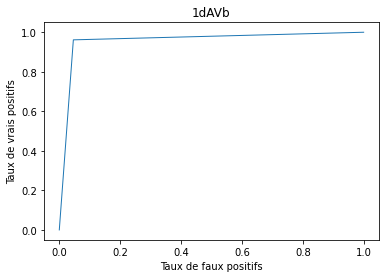

AUC: 0.9576731009315279


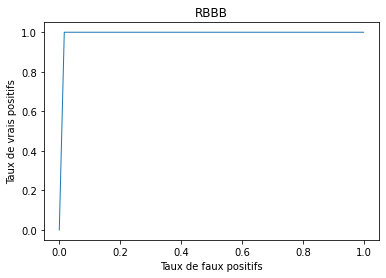

AUC: 0.9918032786885246


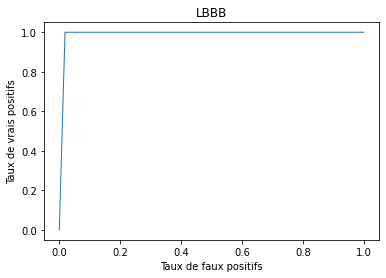

AUC: 0.9905897114178168


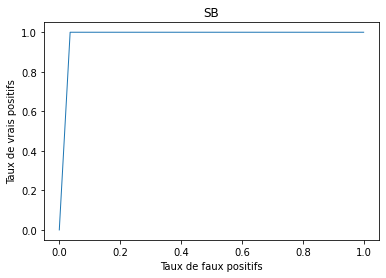

AUC: 0.9821867321867322


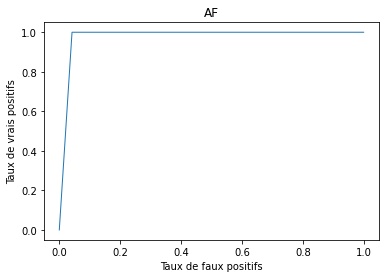

AUC: 0.979089790897909


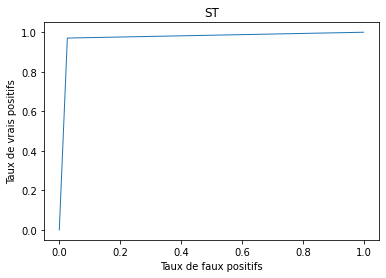

AUC: 0.9720532601439064


In [16]:
for i, l in enumerate(label) :

    fpr, tpr, thresholds = roc_curve(df_Cardiologist2[l], preds1[:,i])
    plt.plot(fpr, tpr, lw=1)
    plt.title(l)
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.show()
    plt.show()

    print("AUC: " + str(roc_auc_score(df_Cardiologist2[l], preds1[:,i])))



#### seuil = 5%

In [17]:
preds2=np.copy(preds)
preds2[preds2 > seuil[1]] = 1
preds2[preds2 != 1] = 0
for i in range(20):  
    print("patient numéro ",index[i],": étiquette : ",list(df_Cardiologist2.iloc[index[i],:6]),", prédiction : ",preds2[i])

patient numéro  0 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  1 : étiquette :  [0, 0, 1, 0, 0, 0] , prédiction :  [0. 0. 1. 0. 0. 0.]
patient numéro  2 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  3 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  4 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  5 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  6 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  7 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  8 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  9 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  10 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  11 : étiquette 

In [18]:
for i, l in enumerate(label) :
    table=pd.crosstab(preds2[:,i],df_Cardiologist2[l])
    vrai_negatif = table[0][0]
    faux_positif = table[0][1]
    faux_negatif = table[1][0]
    vrai_positif = table[1][1]
    precision = vrai_positif/(vrai_positif + faux_positif)
    rappel = vrai_positif/(vrai_positif + faux_negatif)
    specificite = vrai_negatif/(vrai_negatif + faux_positif)
    taux_erreur = (faux_positif + faux_negatif)/(vrai_negatif + faux_positif + faux_negatif + vrai_positif)
    print(table)
    print("précision = ", precision, "rappel = ", rappel)
    print("spécificité = ", specificite, "taux d'erreur = ", taux_erreur)
    print()

1dAVb    0   1
row_0         
0.0    789   1
1.0     12  25
précision =  0.6756756756756757 rappel =  0.9615384615384616
spécificité =  0.9850187265917603 taux d'erreur =  0.015719467956469165

RBBB     0   1
row_0         
0.0    787   0
1.0      6  34
précision =  0.85 rappel =  1.0
spécificité =  0.9924337957124842 taux d'erreur =  0.007255139056831923

LBBB     0   1
row_0         
0.0    796   0
1.0      1  30
précision =  0.967741935483871 rappel =  1.0
spécificité =  0.998745294855709 taux d'erreur =  0.0012091898428053204

SB       0   1
row_0         
0.0    799   0
1.0     15  13
précision =  0.4642857142857143 rappel =  1.0
spécificité =  0.9815724815724816 taux d'erreur =  0.018137847642079808

AF       0   1
row_0         
0.0    802   1
1.0     11  13
précision =  0.5416666666666666 rappel =  0.9285714285714286
spécificité =  0.986469864698647 taux d'erreur =  0.014510278113663845

ST       0   1
row_0         
0.0    781   2
1.0     12  32
précision =  0.7272727272727273

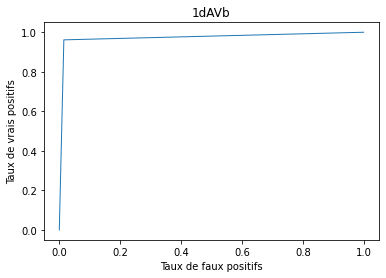

AUC: 0.973278594065111


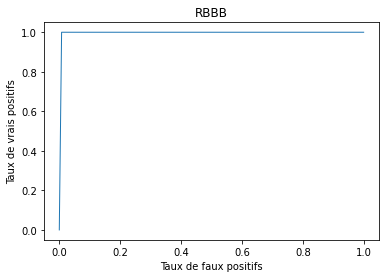

AUC: 0.9962168978562421


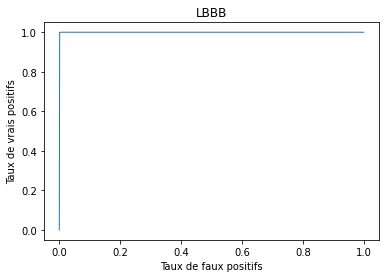

AUC: 0.9993726474278545


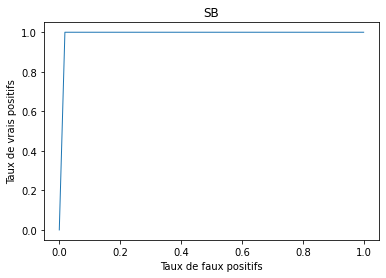

AUC: 0.9907862407862408


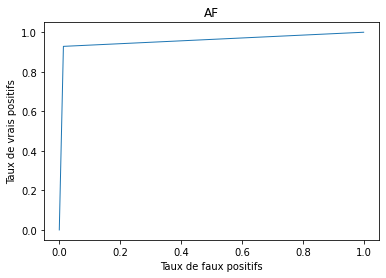

AUC: 0.9575206466350378


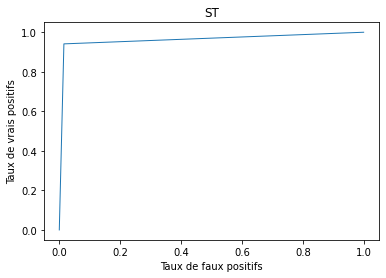

AUC: 0.9630220310066019


In [19]:
for i, l in enumerate(label) :

    fpr, tpr, thresholds = roc_curve(df_Cardiologist2[l], preds2[:,i])
    plt.plot(fpr, tpr, lw=1)
    plt.title(l)
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.show()
    plt.show()

    print("AUC: " + str(roc_auc_score(df_Cardiologist2[l], preds2[:,i])))

#### seuil = 10%

In [20]:
preds3=np.copy(preds)
preds3[preds3 > seuil[2]] = 1
preds3[preds3 != 1] = 0
for i in range(20):  
    print("patient numéro ",index[i],": étiquette : ",list(df_Cardiologist2.iloc[index[i],:6]),", prédiction : ",preds3[i])

patient numéro  0 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  1 : étiquette :  [0, 0, 1, 0, 0, 0] , prédiction :  [0. 0. 1. 0. 0. 0.]
patient numéro  2 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  3 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  4 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  5 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  6 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  7 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  8 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  9 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  10 : étiquette :  [0, 0, 0, 0, 0, 0] , prédiction :  [0. 0. 0. 0. 0. 0.]
patient numéro  11 : étiquette 

In [21]:
for i, l in enumerate(label) :
    table=pd.crosstab(preds3[:,i],df_Cardiologist2[l])
    vrai_negatif = table[0][0]
    faux_positif = table[0][1]
    faux_negatif = table[1][0]
    vrai_positif = table[1][1]
    precision = vrai_positif/(vrai_positif + faux_positif)
    rappel = vrai_positif/(vrai_positif + faux_negatif)
    specificite = vrai_negatif/(vrai_negatif + faux_positif)
    taux_erreur = (faux_positif + faux_negatif)/(vrai_negatif + faux_positif + faux_negatif + vrai_positif)
    print(table)
    print("précision = ", precision, "rappel = ", rappel)
    print("spécificité = ", specificite, "taux d'erreur = ", taux_erreur)
    print()

1dAVb    0   1
row_0         
0.0    791   3
1.0     10  23
précision =  0.696969696969697 rappel =  0.8846153846153846
spécificité =  0.9875156054931336 taux d'erreur =  0.015719467956469165

RBBB     0   1
row_0         
0.0    790   1
1.0      3  33
précision =  0.9166666666666666 rappel =  0.9705882352941176
spécificité =  0.9962168978562421 taux d'erreur =  0.0048367593712212815

LBBB     0   1
row_0         
0.0    797   1
1.0      0  29
précision =  1.0 rappel =  0.9666666666666667
spécificité =  1.0 taux d'erreur =  0.0012091898428053204

SB       0   1
row_0         
0.0    802   1
1.0     12  12
précision =  0.5 rappel =  0.9230769230769231
spécificité =  0.9852579852579852 taux d'erreur =  0.015719467956469165

AF       0   1
row_0         
0.0    805   3
1.0      8  11
précision =  0.5789473684210527 rappel =  0.7857142857142857
spécificité =  0.990159901599016 taux d'erreur =  0.013301088270858524

ST       0   1
row_0         
0.0    785   2
1.0      8  32
précision =  0.

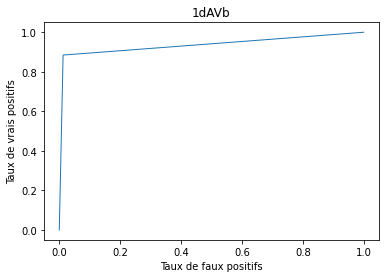

AUC: 0.9360654950542591


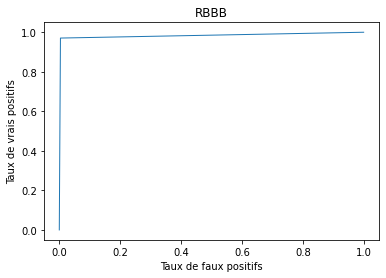

AUC: 0.9834025665751799


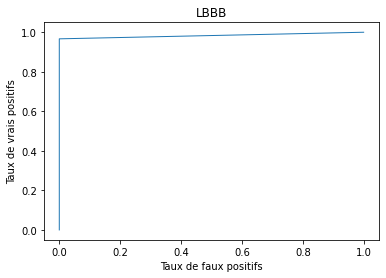

AUC: 0.9833333333333334


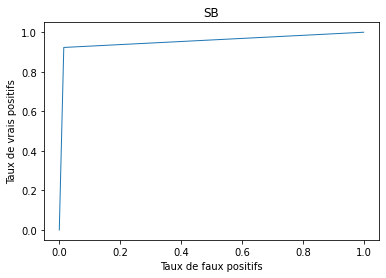

AUC: 0.9541674541674542


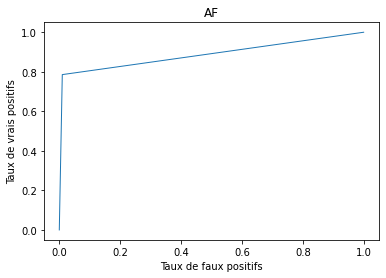

AUC: 0.8879370936566509


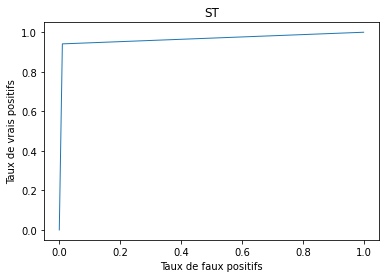

AUC: 0.9655440991024405


In [22]:
for i, l in enumerate(label) :

    fpr, tpr, thresholds = roc_curve(df_Cardiologist2[l], preds3[:,i])
    plt.plot(fpr, tpr, lw=1)
    plt.title(l)
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.show()
    plt.show()

    print("AUC: " + str(roc_auc_score(df_Cardiologist2[l], preds3[:,i])))



On remarque que les courbes ROC semblent montrer que le classifieur se montre particulièrement efficace. En effet, l'allure des courbes ROC sont particulèrement proches de la courbe maximale et la valeur des aires sous la courbe sont élevé. On remarque aussi que les sourbe ROC ont tendance à s'affesser lorsqu'on choisis un seuil plus élevé.